# Indeed Employee Reviews Analysis 


# Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import spacy
import re
import seaborn as sns
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import pyLDAvis 
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore")

In [3]:
nlp=spacy.load("en_core_web_sm")

In [41]:
data=pd.read_csv("employee_reviews.csv",encoding='latin-1')
data=pd.DataFrame({"rating":data["overall-ratings"].values,
                "employee_type":data["job-title"].values,
                "review_text":data["summary"].values})

In [66]:
# Cleaning Employee Type

d1=data["employee_type"].values
for i in range(len(data["employee_type"].values)):
    l=d1[i].split("-")
    d1[i]=l[0].strip()
    d1[i]
data["employee_type"]=d1

data.head()

AttributeError: 'numpy.int64' object has no attribute 'split'

In [67]:
d2=data['review_text'].values
for i in range(len(d2)):
    d2[i]=str(d2[i])
data['review_text']=d2
data
    

,rating,employee_type,review_text
0,5,1,Best Company to work for
1,4,0,"Moving at the speed of light, burn out is inev..."
2,5,1,Great balance between big-company security and...
3,5,1,The best place I've worked and also the most d...
4,5,0,"Unique, one of a kind dream job"
...,...,...,...
67524,3,0,Enriching experience for a beginner but bad fo...
67525,3,1,A complex and interesting experience
67526,4,1,Good Place to Work
67527,3,1,"It's a competitive work place, with overload w..."


In [16]:
# General EDA ( Exploratory Data Analysis )

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67529 entries, 0 to 67528
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         67529 non-null  int64 
 1   employee_type  67529 non-null  object
 2   review_text    67409 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


[Text(0.5, 1.0, 'Ratings Count')]

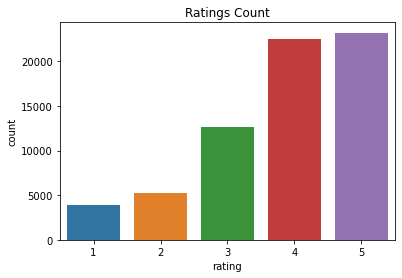

In [31]:
# Total number of reviews by ratings

sns.countplot(data['rating']).set(title='Ratings Count')

In [32]:
# Percentage of reviews by ratings

rating_count=pd.DataFrame(data['rating'].value_counts())
rating_count['percentage']=rating_count['rating']/rating_count['rating'].sum()
print(rating_count)

   rating  percentage
5   23190    0.343408
4   22498    0.333161
3   12653    0.187371
2    5282    0.078218
1    3906    0.057842


[Text(0.5, 1.0, 'Count of Employee Type')]

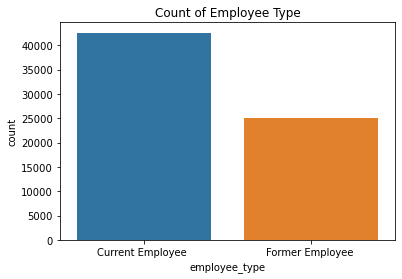

In [43]:
sns.countplot(data['employee_type']).set(title='Count of Employee Type')

[Text(0.5, 1.0, 'Former Employee Review Count')]

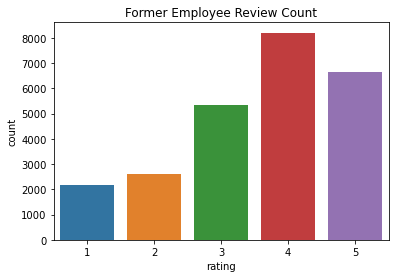

In [54]:
sns.countplot(data[data['employee_type']=="Former Employee"]['rating']).set(title='Former Employee Review Count')

[Text(0.5, 1.0, 'Current Employee')]

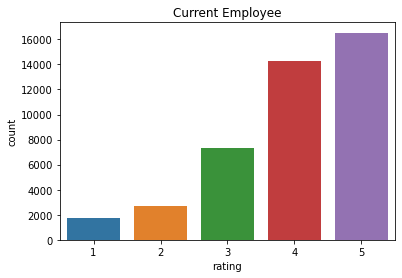

In [53]:
sns.countplot(data[data['employee_type']=="Current Employee"]['rating']).set(title='Current Employee')

In [55]:
#Rename 'Former Employee' to 0 and 'Current Employee to 1'

data['employee_type'].replace({'Former Employee' : 0, 'Current Employee' : 1},inplace=True)

In [56]:
data.head()

,rating,employee_type,review_text
0,5,1,Best Company to work for
1,4,0,"Moving at the speed of light, burn out is inev..."
2,5,1,Great balance between big-company security and...
3,5,1,The best place I've worked and also the most d...
4,5,0,"Unique, one of a kind dream job"


In [58]:
# First three reviews

for text in data['review_text'][0:3]:
    print(text)

Best Company to work for
Moving at the speed of light, burn out is inevitable
Great balance between big-company security and fun, fast-moving projects


# Cleaning Text Data Part 1

In [62]:
#Text cleaning Round 1
def clean_round_1(text):
    text = text.lower()
    text = re.sub(r"i'm","i am",text)
    text = re.sub(r"ihe's","he is",text)
    text = re.sub(r"she's","she is",text)
    text = re.sub(r"that's","that is",text)
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"where's","where is",text)
    text = re.sub(r"don't","do not",text)
    text = re.sub(r"\'ll","will",text)
    text = re.sub(r"\'ve","have",text)
    text = re.sub(r"\'re","are",text)
    text = re.sub(r"\'d","would",text)
    text = re.sub(r"won't","will not",text)
    text = re.sub(r"can't","cannot",text)
    text = re.sub("[^A-Za-z]", " ",text)
    return text

In [143]:
data['clean_1']=data['review_text'].apply(clean_round_1)
data['clean_1']

0                                 best company to work for
1        moving at the speed of light  burn out is inev...
2        great balance between big company security and...
3        the best place ihave worked and also the most ...
4                          unique  one of a kind dream job
                               ...                        
67524    enriching experience for a beginner but bad fo...
67525                 a complex and interesting experience
67526                                   good place to work
67527    it s a competitive work place  with overload w...
67528                                     used to be great
Name: clean_1, Length: 67529, dtype: object

# Cleaning Text Data Part-2

In [144]:
def clean_round_2(text):
    text=" ".join([word for word in text])
    doc=nlp(text)
    text = [word.lemma_ for word in doc]
    text = [word for word in text if word not in nlp.Defaults.stop_words]
    text = "".join([word for word in text])
    return text

In [151]:
data['clean_2'] = data['review_text'].apply(clean_round_2)
data['clean_2']

0                              best  compny  to  work  for
1        MovIng  t  the  speed  of  lIght,  burn  out  ...
2        gret  blnce  between  bIg-compny  securIty  nd...
3        the  best  plce  I've  worked  nd  lso  the  m...
4                      unIque,  one  of    kInd  drem  job
                               ...                        
67524    enrIchIng  experIence  for    begInner  but  b...
67525                 complex  nd  InterestIng  experIence
67526                                 good  plce  to  work
67527    It's    competItIve  work  plce,  wIth  overlo...
67528                                   used  to  be  gret
Name: clean_2, Length: 67529, dtype: object

# LDA Topic Modeling

In [146]:
#LDA Topic Modeling 

In [159]:
text_data = data['clean_2']
text_data.head()

0                        [best, compny, to, work, for]
1    [MovIng, t, the, speed, of, lIght,, burn, out,...
2    [gret, blnce, between, bIg-compny, securIty, n...
3    [the, best, plce, I've, worked, nd, lso, the, ...
4                  [unIque,, one, of, kInd, drem, job]
Name: clean_2, dtype: object

In [161]:
from gensim.corpora import Dictionary

id2word =Dictionary(text_data)
texts = text_data

In [162]:
corpus = [id2word.doc2bow(word) for word in texts]

In [163]:
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [166]:
lda_model = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [169]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,id2word,mds="mmds",R=20)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.410633  0.252077       1        1  26.864949
5      0.117954  0.420234       2        1  11.841333
9     -0.344367 -0.268821       3        1  10.816773
7     -0.244010  0.400527       4        1   9.390740
1      0.192171 -0.422950       5        1   8.653118
2     -0.164120  0.148838       6        1   7.727310
8     -0.090302 -0.377564       7        1   7.353770
0     -0.449942  0.018721       8        1   7.163423
4      0.158490 -0.042674       9        1   5.625598
6      0.413492 -0.128388      10        1   4.562986, topic_info=          Term          Freq         Total Category  logprob  loglift
1       compny   8501.000000   8501.000000  Default  20.0000  20.0000
74        good   9061.000000   9061.000000  Default  19.0000  19.0000
3           to  14354.000000  14354.000000  Default  18.0000  18.0000
20        gret  12652.000000  12652.000000  Default  17.0000  17.0000
21          nd   6888.000000   6888.000000  Default  16.0000  16.0000
...        ...           ...           ...      ...      ...      ...
121      hours    158.443139    159.233658  Topic10  -4.4341   3.0822
30        drem    153.269428    154.060073  Topic10  -4.4673   3.0820
907   terrIble    144.027224    144.817596  Topic10  -4.5295   3.0817
368    process    142.407879    143.198247  Topic10  -4.5408   3.0817
1034   chngIng    131.896693    132.687060  Topic10  -4.6175   3.0812

[223 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
323        8  0.997085     &
169        8  0.999102     -
1434       9  0.991295     @
17068      4  0.994503  GTsc
17068      8  0.003870  GTsc
...      ...       ...   ...
248        7  0.999368    ws
836        4  0.998499    wy
992        4  0.998215  yers
102        6  0.999822   you
461        1  0.999256  your

[209 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 10, 8, 2, 3, 9, 1, 5, 7])

In [96]:
# If you wiil notice in the topic modeling we have a lot of single word and that is not adding any to value to the data, So I am going to remove all the single and double words text from the data. 

# Cleaning Text Data Part-3

In [170]:
def remove_words(text):
    final_words = []
    for word in text:
        if len(word) > 2:
            final_words.append(word)
    return final_words

In [171]:
data['clean_2'] = data['clean_2'].apply(remove_words)

# After removing the single and double words from the data

In [172]:
#Top 20 Topics for Former Employees

In [173]:
#Top 20 Topics for Current Employees

# Sentiment analysis using NLTK's VADER

In [174]:
#Extracting Negative, Neutral, Positive and Compound Score

In [175]:
import nltk

In [176]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [177]:
sia = SentimentIntensityAnalyzer()

In [189]:
data['clean_2'] = data['review_text'].apply(clean_round_2)


In [190]:
data['clean_2']

0                              best  compny  to  work  for
1        MovIng  t  the  speed  of  lIght,  burn  out  ...
2        gret  blnce  between  bIg-compny  securIty  nd...
3        the  best  plce  I've  worked  nd  lso  the  m...
4                      unIque,  one  of    kInd  drem  job
                               ...                        
67524    enrIchIng  experIence  for    begInner  but  b...
67525                 complex  nd  InterestIng  experIence
67526                                 good  plce  to  work
67527    It's    competItIve  work  plce,  wIth  overlo...
67528                                   used  to  be  gret
Name: clean_2, Length: 67529, dtype: object

In [191]:
data['scores'] = data['clean_2'].apply(lambda review: sia.polarity_scores(review))

In [192]:
print(data['scores'][0])
print(data['scores'][1])
print(data['scores'][2])

{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.6369}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.551, 'pos': 0.449, 'compound': 0.6908}


In [193]:
data['compound'] = data['scores'].apply(lambda score: score['compound'])

# Extracting Compound score

In [194]:
data['compound'] = data['scores'].apply(lambda score: score['compound'])

In [195]:
data['compound'][0:10]

0    0.6369
1    0.0000
2    0.6908
3    0.6369
4    0.5267
5    0.0000
6    0.0000
7    0.4215
8    0.0000
9    0.0000
Name: compound, dtype: float64

# Cleaning label columns using simple function 

In [197]:
def labels(score):
    if score<3:
        return 'neg'
    elif score >3:
        return 'pos'
    else:
        return 'neu'

In [198]:
data['label'] = data['rating'].apply(labels)

In [199]:
data['label'][0:10]

0    pos
1    pos
2    pos
3    pos
4    pos
5    pos
6    pos
7    pos
8    pos
9    pos
Name: label, dtype: object

# Creating Negative,Neutral and Positive from the compound column

In [200]:
def compound_score(score):
    if score<0:
        return 'neg'
    elif score > 0:
        return 'pos'
    else:
        return 'neu'

In [201]:
data['compound_score'] = data['compound'].apply(compound_score)

In [202]:
data['compound_score'][0:10]

0    pos
1    neu
2    pos
3    pos
4    pos
5    neu
6    neu
7    pos
8    neu
9    neu
Name: compound_score, dtype: object

# Quick comparison between original label vs. compound label

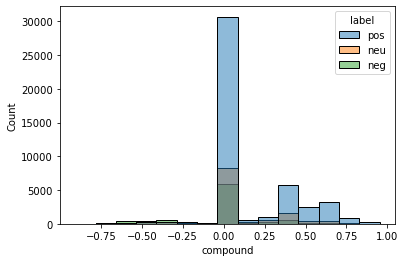

In [203]:
sns.histplot(x='compound',data=data,bins=15,hue='label');

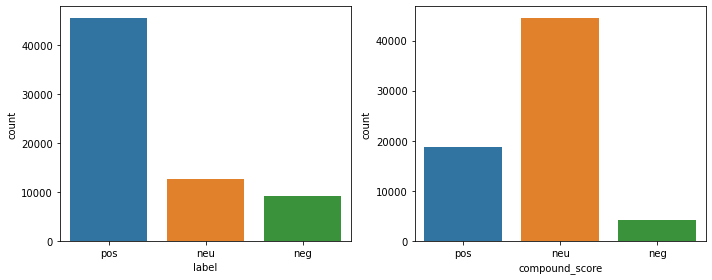

In [204]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

sns.countplot(data['label'],ax=ax[0])
sns.countplot(data['compound_score'],ax=ax[1])
fig.tight_layout()
fig.show()

In [205]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [206]:
accuracy_score(data['label'],data['compound_score'])

0.3574168135171556

In [207]:
print(confusion_matrix(data['label'],data['compound_score']))

[[ 1905  5828  1455]
 [ 1084  8214  3355]
 [ 1115 30556 14017]]


In [208]:
print(classification_report(data['label'],data['compound_score']))

              precision    recall  f1-score   support

         neg       0.46      0.21      0.29      9188
         neu       0.18      0.65      0.29     12653
         pos       0.74      0.31      0.43     45688

    accuracy                           0.36     67529
   macro avg       0.46      0.39      0.34     67529
weighted avg       0.60      0.36      0.39     67529



# Applying machine learning model to predict ratings based on text data

In [209]:
X_train = data.loc[:9100, 'clean_2'].values
y_train = data.loc[:9100,'rating'].values
X_test = data.loc[:9101, 'clean_2'].values
y_test = data.loc[:9101,'rating'].values

In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [213]:
vectorizer = TfidfVectorizer()

In [214]:
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [215]:
print(train_vectors.shape,test_vectors.shape)

(9101, 3322) (9102, 3322)


# Applying multinominal Naive Bayes algorithm

In [216]:
from sklearn.naive_bayes import MultinomialNB

In [217]:
clf = MultinomialNB()

In [218]:
clf.fit(train_vectors,y_train)

MultinomialNB()

In [219]:
predicted = clf.predict(test_vectors)

In [220]:
accuracy_score(y_test,predicted)

0.6219512195121951

In [142]:
# Conclusion:
